# Required Libraries (install with pip)
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Load Training and Test Data

In [2]:
training_df = pd.read_excel("recruiting_zeta-disease_training-data_take-home-challenge.xlsx")
test_df = pd.read_excel("recruiting_zeta-disease_prediction-data_take-home-challenge.xlsx")

## Exploratory Data Analysis

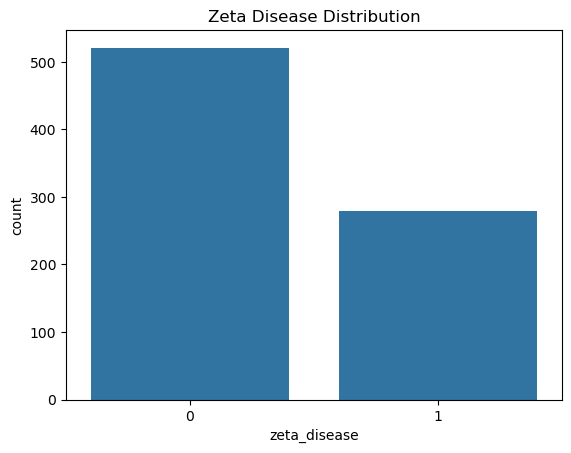

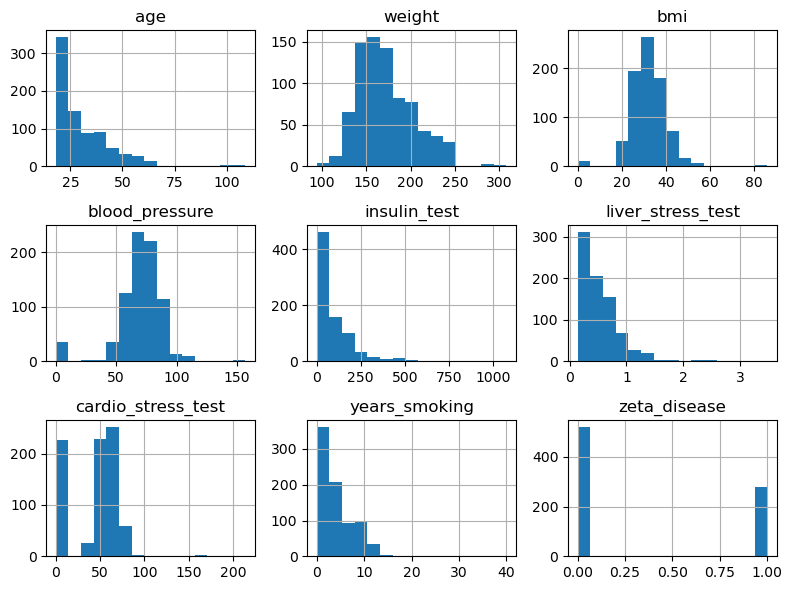

In [3]:
# Distribution of target
sns.countplot(x='zeta_disease', data=training_df)
plt.title("Zeta Disease Distribution")
plt.show()

# Histograms of variables
training_df.hist(bins=15, figsize=(8, 6))
plt.tight_layout()
plt.show()

## Feature Engineering

In [4]:
# Applying to both train and test
def add_engineered_features(X):
    X = X.copy()
    X['bmi_age_ratio'] = X['bmi'] / (X['age'] + 1)
    X['smoke_bmi_ratio'] = X['years_smoking'] / (X['bmi'] + 1)
    X['bmi_weight_ratio'] = X['bmi'] / (X['weight'] + 1)
    X['bp_age_ratio'] = X['blood_pressure'] / (X['age'] + 1)
    return X

X = add_engineered_features(training_df.drop(columns=["zeta_disease"]))
y = training_df["zeta_disease"]
X_test = add_engineered_features(test_df.drop(columns=["zeta_disease"]))

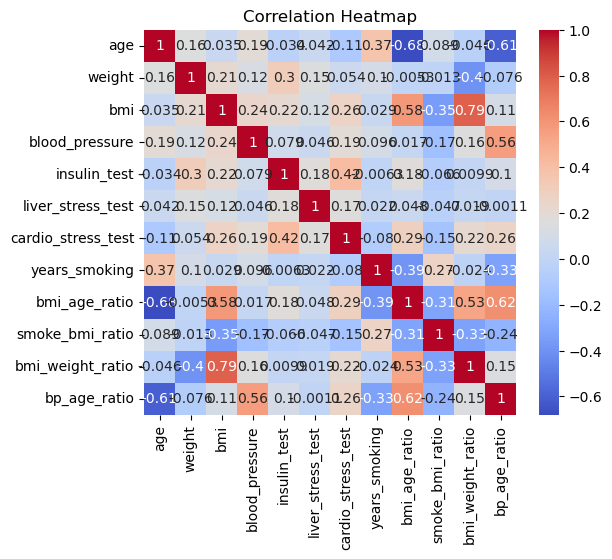

In [5]:
# Correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## Handling Imbalance with SMOTE

In [6]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

## Train-Test Split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

## Hyperparameter Tuning with Cross-Validation

In [8]:
# Defining parameter grid for XGBoost Model
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 2]
}

# Building the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(eval_metric='logloss',random_state=42))
])

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

# Best estimator
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 10, 'classifier__n_estimators': 100}


In [9]:
# Sorting cross-validation results for all trained models
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values(by="mean_test_score", ascending=False)

# Displaying top results
cv_results[['param_classifier__n_estimators', 'param_classifier__max_depth', 
            'param_classifier__learning_rate', 'mean_test_score', 'std_test_score']].head(10)

,param_classifier__n_estimators,param_classifier__max_depth,param_classifier__learning_rate,mean_test_score,std_test_score
31,100,10,0.2,0.835777,0.059982
30,50,10,0.2,0.834504,0.061054
19,100,10,0.1,0.834256,0.057916
32,200,10,0.2,0.830628,0.064798
20,200,10,0.1,0.830364,0.063260
35,200,None,0.2,0.827259,0.063498
18,50,10,0.1,0.826423,0.054835
34,100,None,0.2,0.825072,0.059878
16,100,5,0.1,0.823985,0.065800
15,50,5,0.1,0.822959,0.054725


## Evaluation - Classification Report and Confusion Matrix

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00       104

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209



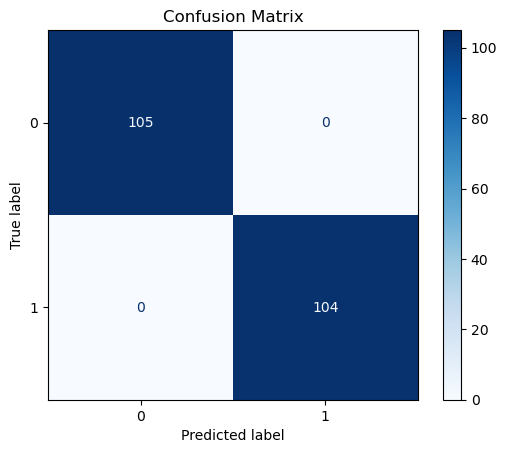

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

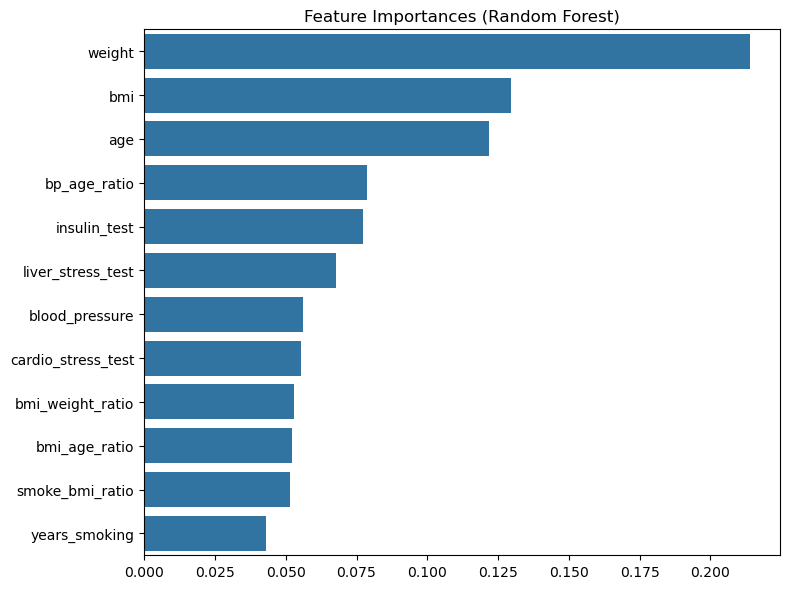

In [11]:
# Extract feature importances if model supports it
if hasattr(best_model.steps[1][1], 'feature_importances_'):
    importances = best_model.steps[1][1].feature_importances_
    feature_names = add_engineered_features(X_val.copy()).columns
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=importances[sorted_idx], y=np.array(feature_names)[sorted_idx])
    plt.title("Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this classifier.")

## ROC Curve

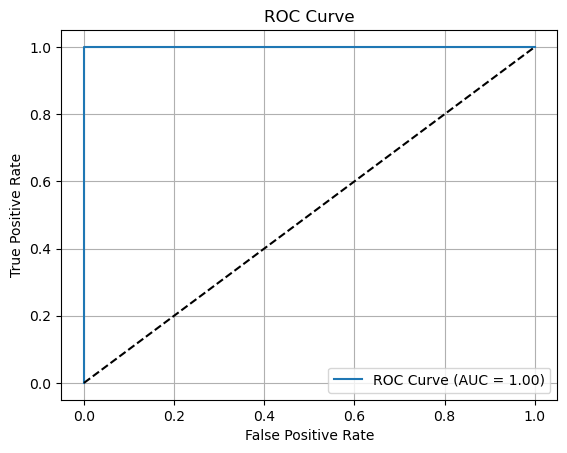

In [12]:
y_probs = best_model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_probs)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

## Final Prediction and Export

In [14]:
test_df['zeta_disease'] = best_model.predict(X_test)
test_df.to_excel("recruiting_zeta-disease_prediction-data_take-home-challenge_answer.xlsx", index=False)
test_df[['zeta_disease']].head()

,zeta_disease
0,1
1,1
2,0
3,1
4,0
